In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fetch historical data
def fetch_data(symbol, timeframe, since, limit):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Preprocess the data
def preprocess_data(df):
    # Handle missing values
    # df = df.dropna()

    # Ensure data is sorted by timestamp
    df = df.sort_values('timestamp')

    # Add additional features if needed (e.g., moving averages)
    df['ma_20'] = df['close'].rolling(window=20).mean()
    df['ma_50'] = df['close'].rolling(window=50).mean()
    df = df.dropna()
    return df

# Initialize the exchange
exchange = ccxt.binance()

# Example usage
symbol = 'BTC/USDT'
timeframe = '1d'  # 1 day intervals
since = exchange.parse8601('2020-01-01T00:00:00Z')  # Start date
limit = 500000  # Number of data points

data = fetch_data(symbol, timeframe, since, limit)
data = preprocess_data(data)

data.head()

,timestamp,open,high,low,close,volume,ma_20,ma_50
49,2020-02-19,10164.78,10250.00,9350.00,9593.79,55162.586895,9803.2345,8928.3434
50,2020-02-20,9594.65,9699.00,9400.00,9596.42,60152.342914,9815.4110,8976.2548
51,2020-02-21,9597.21,9755.51,9550.21,9677.05,42181.554524,9830.0330,9030.4816
52,2020-02-22,9677.05,9709.17,9560.02,9650.86,24636.757623,9846.0005,9076.5996
53,2020-02-23,9650.85,9990.00,9645.00,9936.40,37702.089843,9878.2085,9128.2454


## Stationarity

In [3]:
# Augmented Dickey-Fuller (ADF) Test check for data stationarity
# stationary if its statistical properties, such as mean, variance, and autocorrelation, are constant over time. 

from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(data['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))


ADF Statistic: -1.4332195539878454
p-value: 0.5662507504411409
Critical Value (1%): -3.437
Critical Value (5%): -2.865
Critical Value (10%): -2.568


## Insights

null hypothesis = Close price is stationary (data exhibit known statistical properties)

1. ADF > all critical values
2. p-value > 5% significane level

Thus, we reject null hypothesis, accept alternative hypothesis, that Close price is non Stationary.

Since the ADF statistic (-1.569) is not less than any of the critical values (-3.437 at 1%, -2.865 at 5%, and -2.568 at 10%), and the p-value (0.499) is much higher than 0.05, we fail to reject the null hypothesis that the time series of close price is Non-Stationary.

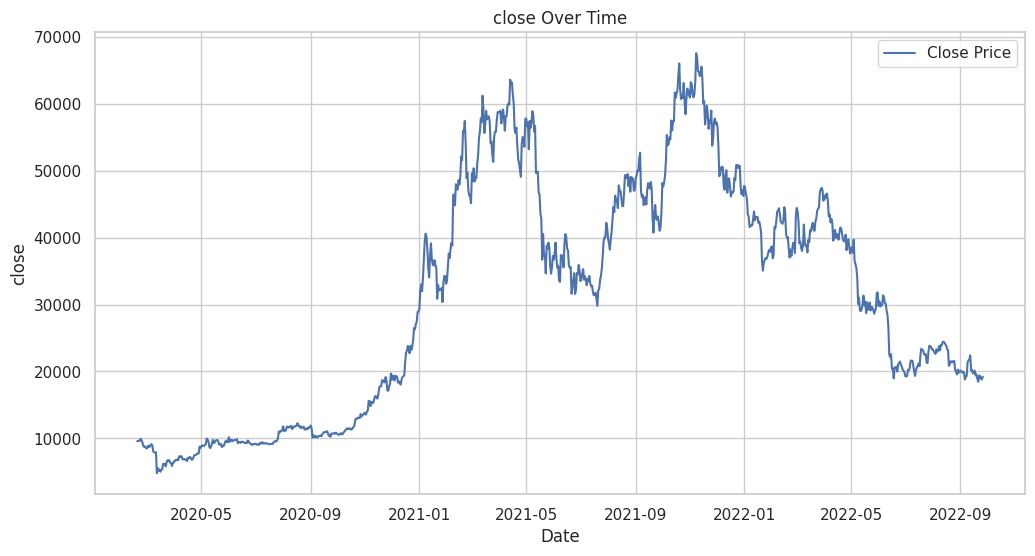

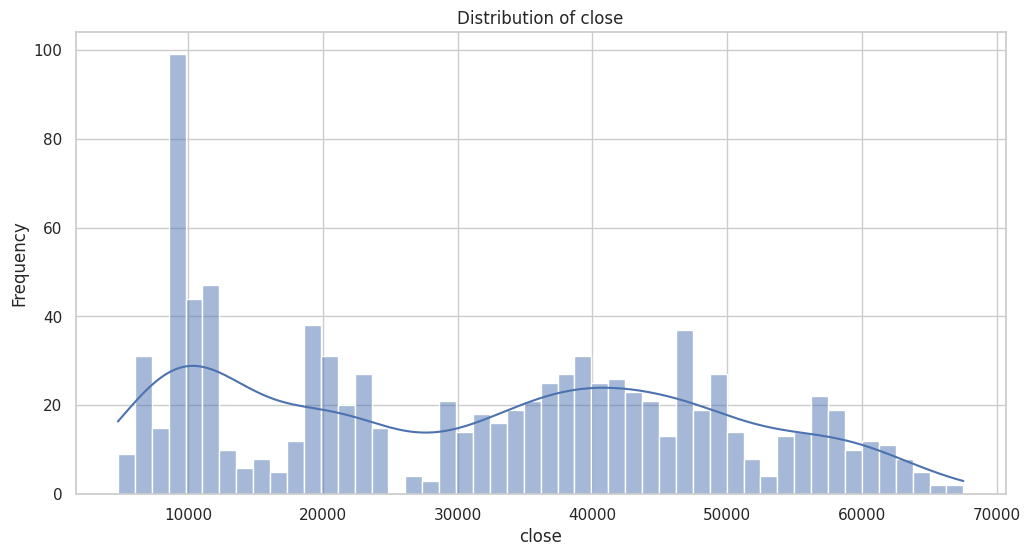

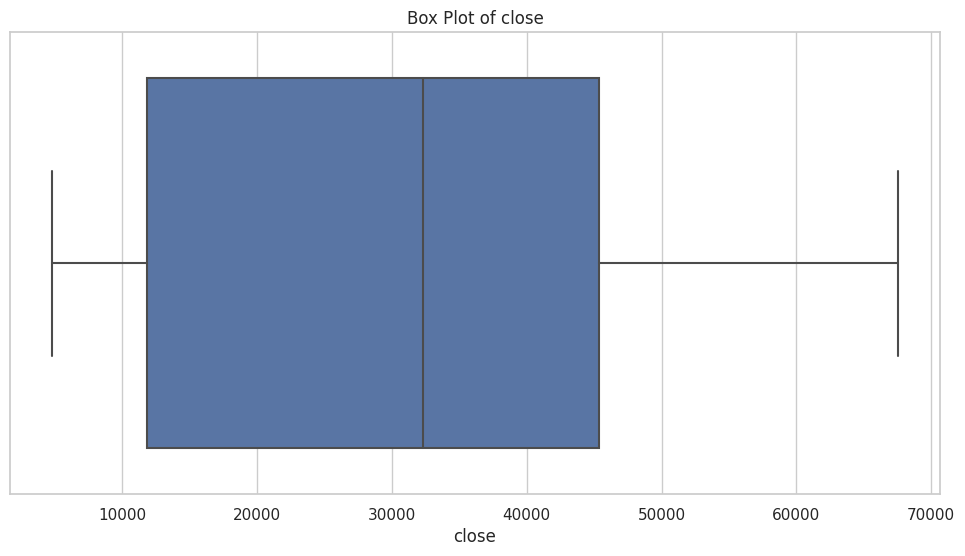

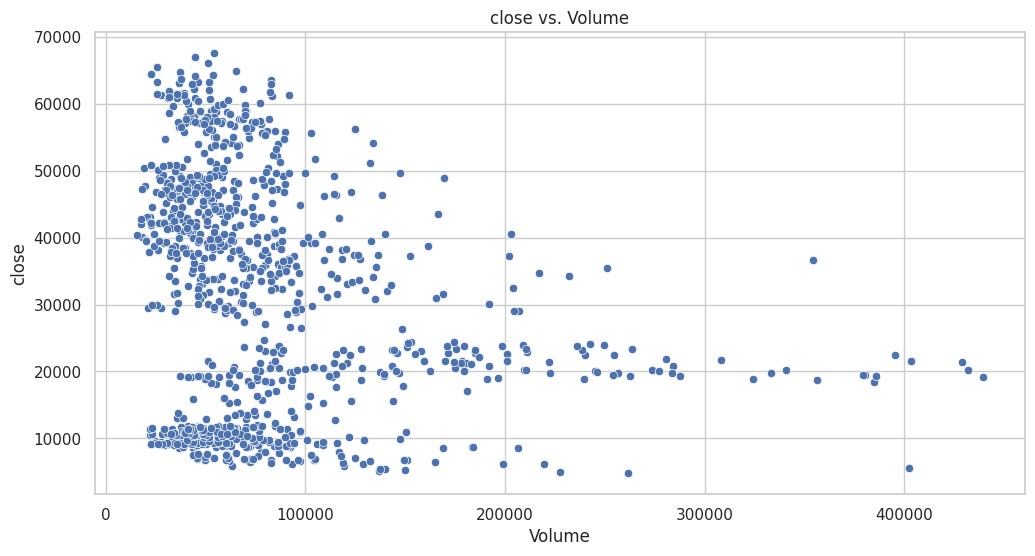

In [4]:

def plot_visualizations(df, source_name):
    # Set the plot style
    sns.set(style="whitegrid")

    # Line plot of closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df[source_name], label='Close Price')
    plt.title(f'{source_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel(source_name)
    plt.legend()
    plt.show()

    # Histogram of closing prices
    plt.figure(figsize=(12, 6))
    sns.histplot(df[source_name], bins=50, kde=True)
    plt.title(f'Distribution of {source_name}')
    plt.xlabel(source_name)
    plt.ylabel('Frequency')
    plt.show()

    # Box plot of closing prices
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[source_name])
    plt.title(f'Box Plot of {source_name}')
    plt.xlabel(source_name)
    plt.show()

    # Scatter plot of closing price vs. volume
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=df['volume'], y=df[source_name])
    plt.title(f'{source_name} vs. Volume')
    plt.xlabel('Volume')
    plt.ylabel(source_name)
    plt.show()

plot_visualizations(data, 'close')

## Insights
1. Data distribution seems to be -ve skewed.

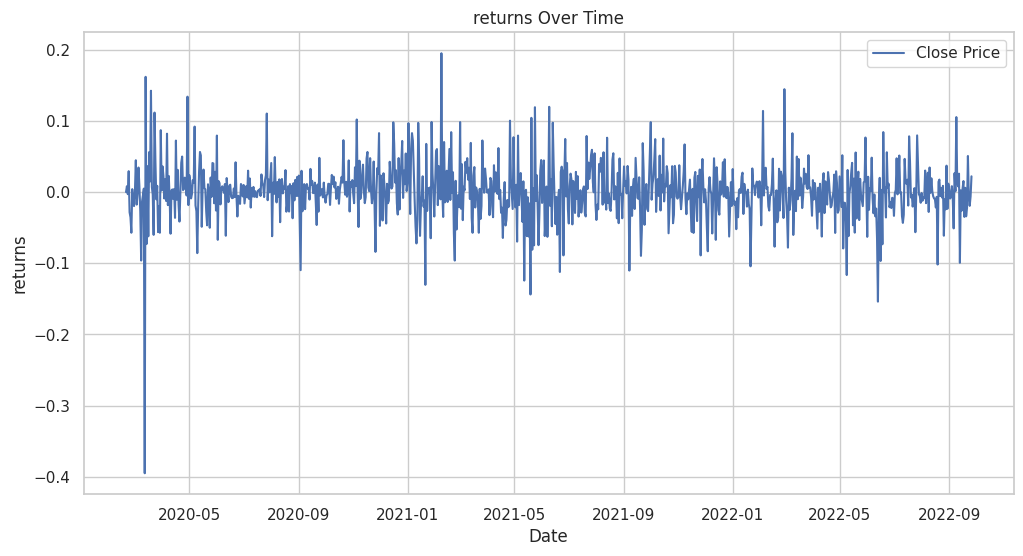

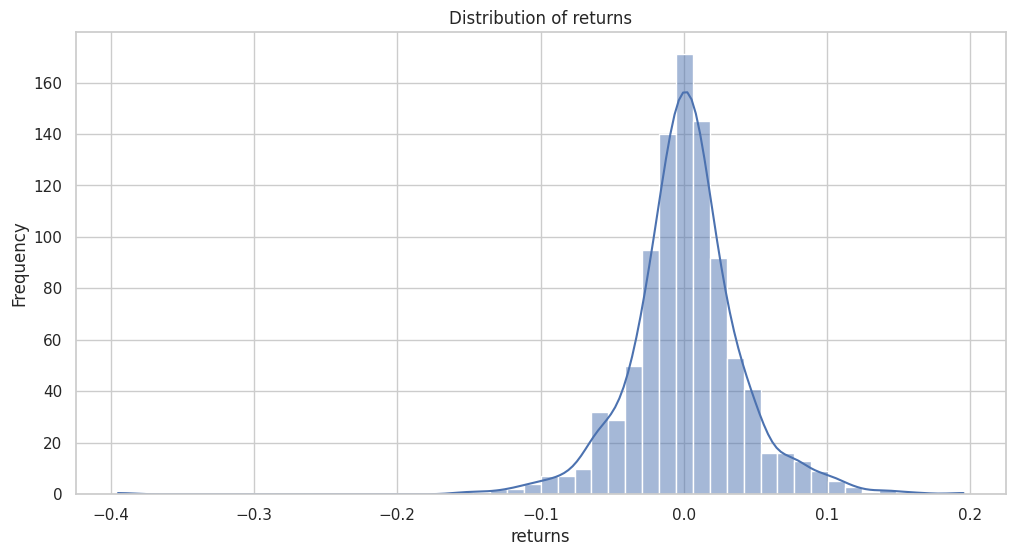

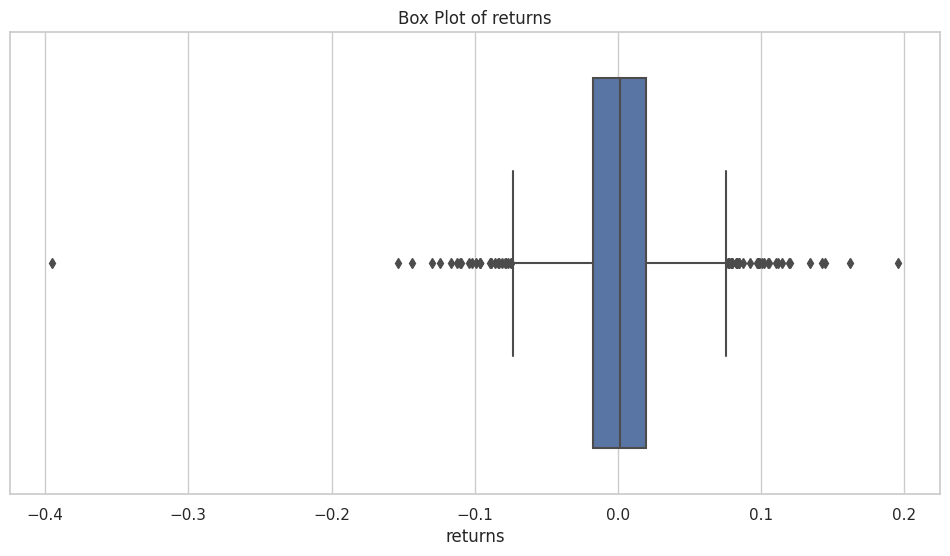

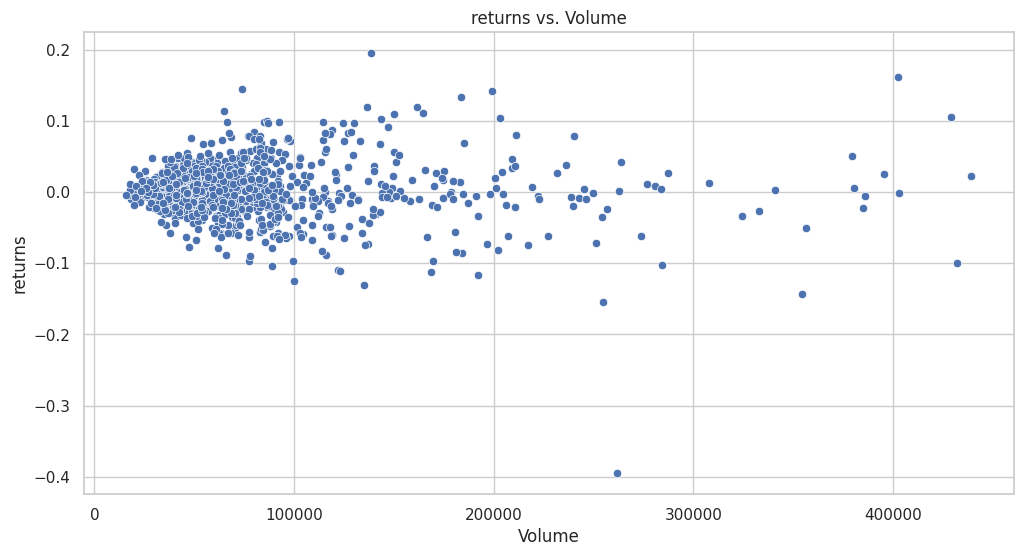

In [5]:
data['returns'] = data['close'].pct_change()

data.dropna(inplace=True)
plot_visualizations(data, 'returns')

## Insights

1. Data is Normalized 

Since data is normalized but memory of previous value could not sustained

Mean Squared Error: 88408.91643328348
Mean Squared Error: 8832399.462922398


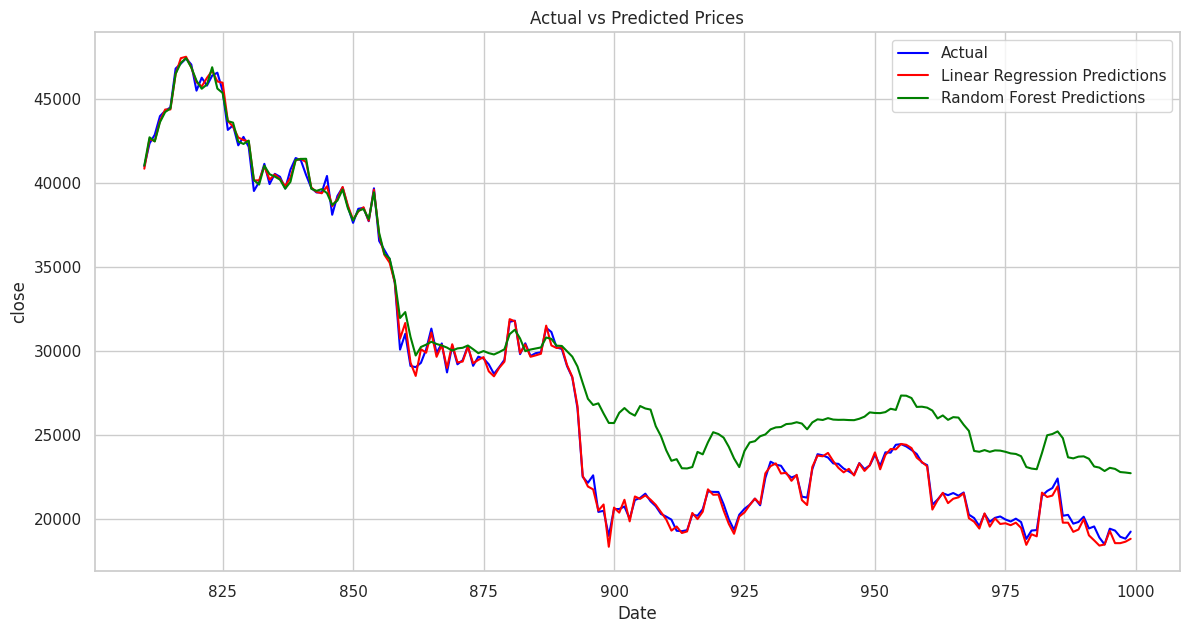

In [6]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create features for the model
def create_features(df, lags, y_label):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[y_label].shift(lag)
    df = df.dropna()
    return df

# Split the data into training and test sets
def split_data(df, test_size=0.2, y_label="close"):
    X = df.drop(['timestamp', y_label], axis=1)
    y = df[y_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    return X_train, X_test, y_train, y_test

# Train Linear Regression Model
def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

# Train Random Forest Model
def train_random_forest(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Predict and evaluate the models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    return y_pred

# Plot the results
def plot_predictions(y_test, y_pred_lr, y_pred_rf, y_label):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, y_pred_lr, label='Linear Regression Predictions', color='red')
    plt.plot(y_test.index, y_pred_rf, label='Random Forest Predictions', color='green')
    plt.legend()
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.show()


# Split data
X_train, X_test, y_train, y_test = split_data(data, 0.2,'close')

# Train models
lr_model = train_linear_regression(X_train, y_train)
rf_model = train_random_forest(X_train, y_train)

# Evaluate models
y_pred_lr = evaluate_model(lr_model, X_test, y_test)
y_pred_rf = evaluate_model(rf_model, X_test, y_test)

# Plot predictions
plot_predictions(y_test, y_pred_lr, y_pred_rf, "close")

Mean Squared Error: 0.00022689224719519045
Mean Squared Error: 0.0016487570445833683


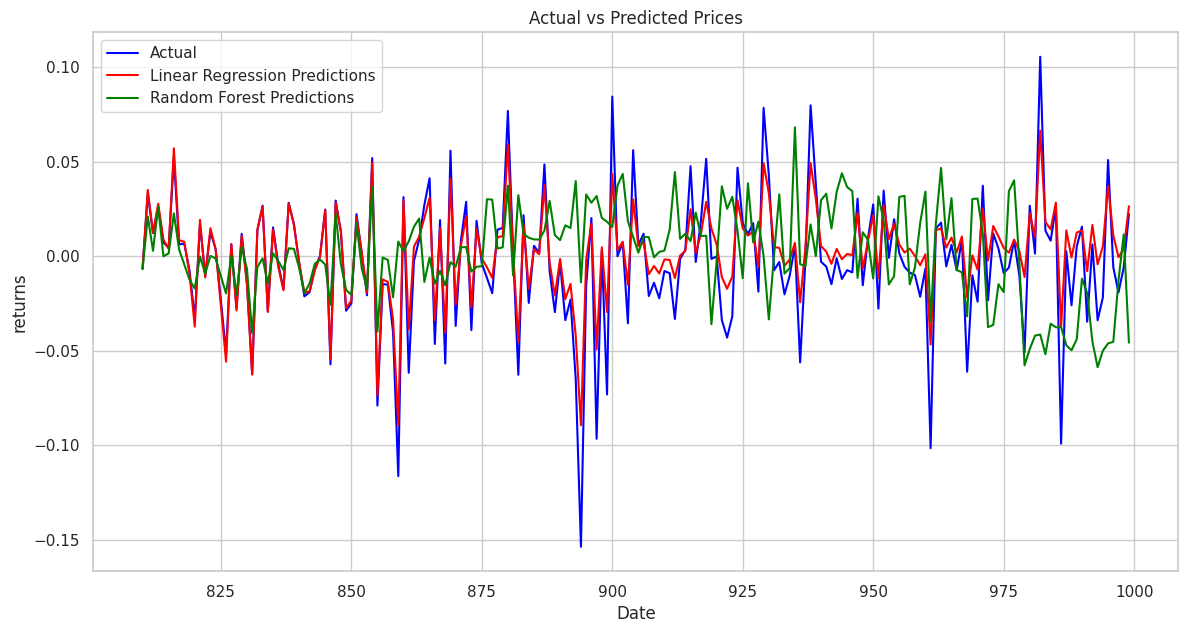

In [7]:
# Split data
X_train, X_test, y_train, y_test = split_data(data, 0.2,'returns')

# Train models
lr_model = train_linear_regression(X_train, y_train)
rf_model = train_random_forest(X_train, y_train)

# Evaluate models
y_pred_lr = evaluate_model(lr_model, X_test, y_test)
y_pred_rf = evaluate_model(rf_model, X_test, y_test)

# Plot predictions
plot_predictions(y_test, y_pred_lr, y_pred_rf, "returns")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Indexes of detected anomalies in training data: [0, 322, 323, 324, 329, 367, 372, 373, 374, 387, 418, 419, 420, 421, 422, 442, 443, 444, 445, 446, 454, 456, 458, 516, 579, 585, 586, 587, 608, 627, 628, 633, 687, 732, 734, 758]
Indexes of detected anomalies in testing data: [0, 1, 2, 3, 4, 5, 6]


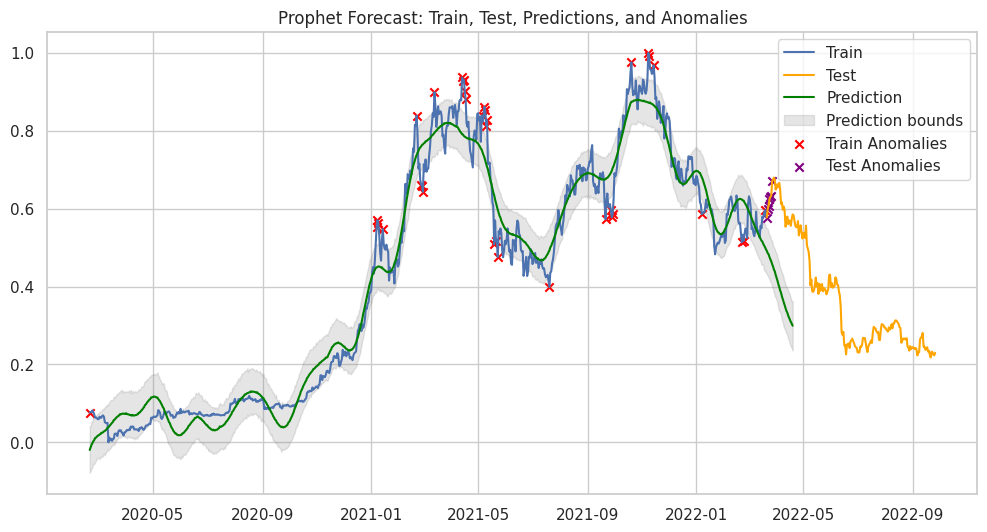

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet

# Function to train Prophet model
def train_prophet_model(df):
    df_prophet = df.reset_index().rename(columns={'timestamp': 'ds', 'close': 'y'})
    model = Prophet()
    model.fit(df_prophet)
    return model

# Function to forecast using Prophet model
def forecast_prophet(model, periods=7):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast

# Function to detect anomalies using Prophet
def detect_anomalies_prophet(df, forecast, threshold=2):
    df = df.reset_index().rename(columns={'timestamp': 'ds', 'close': 'y'})
    residuals = df['y'] - forecast['yhat'][:len(df)]
    std_dev = np.std(residuals)
    anomalies = residuals[np.abs(residuals) > threshold * std_dev]
    anomaly_indexes = anomalies.index
    return anomalies, anomaly_indexes

# # Example data
# data = pd.DataFrame({
#     'timestamp': pd.date_range(start='2022-01-01', periods=365, freq='D'),
#     'close': np.sin(np.linspace(0, 3 * np.pi, 365)) + np.random.normal(scale=0.5, size=365)
# })

# Normalize data
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(data[['close']])

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Train the Prophet model on the training data
prophet_model = train_prophet_model(train_data)

# Forecast the next 7 days
prophet_forecast = forecast_prophet(prophet_model, periods=30)

# Detect anomalies in the training data
train_forecast = prophet_forecast.iloc[:len(train_data)]
train_anomalies, train_anomaly_indexes = detect_anomalies_prophet(train_data, train_forecast)

# Detect anomalies in the next 7 days forecast
# Note: Align the forecast data to the test data
test_forecast = prophet_forecast.iloc[len(train_data):len(train_data) + 7].reset_index(drop=True)
test_data_subset = test_data.iloc[:7].reset_index(drop=True)
test_anomalies, test_anomaly_indexes = detect_anomalies_prophet(test_data_subset, test_forecast)

# Print the indexes of detected anomalies
print("Indexes of detected anomalies in training data:", train_anomaly_indexes.tolist())
print("Indexes of detected anomalies in testing data:", test_anomaly_indexes.tolist())

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['timestamp'], train_data['close'], label='Train')
plt.plot(test_data['timestamp'], test_data['close'], label='Test', color='orange')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prediction', color='green')
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2, label='Prediction bounds')
plt.scatter(train_data.iloc[train_anomaly_indexes]['timestamp'], train_data.iloc[train_anomaly_indexes]['close'], color='red', label='Train Anomalies', marker='x')
plt.scatter(test_data.iloc[test_anomaly_indexes]['timestamp'], test_data.iloc[test_anomaly_indexes]['close'], color='purple', label='Test Anomalies', marker='x')
plt.legend()
plt.title('Prophet Forecast: Train, Test, Predictions, and Anomalies')
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Indexes of detected anomalies in training data: [17, 21, 22, 28, 32, 69, 77, 158, 196, 259, 300, 317, 328, 336, 343, 354, 369, 375, 431, 447, 454, 455, 459, 475, 479, 487, 491, 493, 565, 578, 589, 645, 701, 715, 739, 748]
Indexes of detected anomalies in testing data: [6]


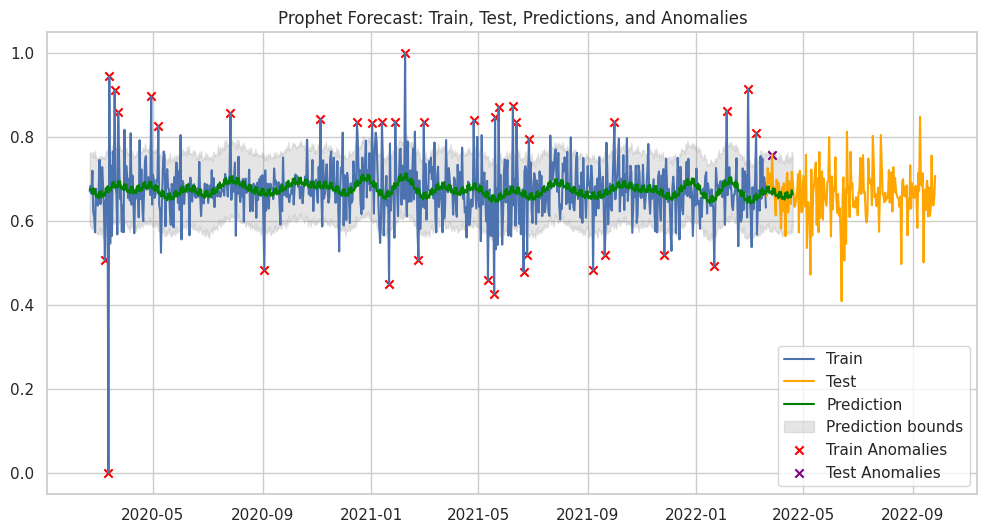

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet

# Function to train Prophet model
def train_prophet_model(df):
    df_prophet = df.reset_index().rename(columns={'timestamp': 'ds', 'returns': 'y'})
    model = Prophet()
    model.fit(df_prophet)
    return model

# Function to forecast using Prophet model
def forecast_prophet(model, periods=7):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast

# Function to detect anomalies using Prophet
def detect_anomalies_prophet(df, forecast, threshold=2):
    df = df.reset_index().rename(columns={'timestamp': 'ds', 'returns': 'y'})
    residuals = df['y'] - forecast['yhat'][:len(df)]
    std_dev = np.std(residuals)
    anomalies = residuals[np.abs(residuals) > threshold * std_dev]
    anomaly_indexes = anomalies.index
    return anomalies, anomaly_indexes

# # Example data
# data = pd.DataFrame({
#     'timestamp': pd.date_range(start='2022-01-01', periods=365, freq='D'),
#     'close': np.sin(np.linspace(0, 3 * np.pi, 365)) + np.random.normal(scale=0.5, size=365)
# })

# Normalize data
scaler = MinMaxScaler()
data['returns'] = scaler.fit_transform(data[['returns']])

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Train the Prophet model on the training data
prophet_model = train_prophet_model(train_data)

# Forecast the next 7 days
prophet_forecast = forecast_prophet(prophet_model, periods=30)

# Detect anomalies in the training data
train_forecast = prophet_forecast.iloc[:len(train_data)]
train_anomalies, train_anomaly_indexes = detect_anomalies_prophet(train_data, train_forecast)

# Detect anomalies in the next 7 days forecast
# Note: Align the forecast data to the test data
test_forecast = prophet_forecast.iloc[len(train_data):len(train_data) + 7].reset_index(drop=True)
test_data_subset = test_data.iloc[:7].reset_index(drop=True)
test_anomalies, test_anomaly_indexes = detect_anomalies_prophet(test_data_subset, test_forecast)

# Print the indexes of detected anomalies
print("Indexes of detected anomalies in training data:", train_anomaly_indexes.tolist())
print("Indexes of detected anomalies in testing data:", test_anomaly_indexes.tolist())

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['timestamp'], train_data['returns'], label='Train')
plt.plot(test_data['timestamp'], test_data['returns'], label='Test', color='orange')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prediction', color='green')
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2, label='Prediction bounds')
plt.scatter(train_data.iloc[train_anomaly_indexes]['timestamp'], train_data.iloc[train_anomaly_indexes]['returns'], color='red', label='Train Anomalies', marker='x')
plt.scatter(test_data.iloc[test_anomaly_indexes]['timestamp'], test_data.iloc[test_anomaly_indexes]['returns'], color='purple', label='Test Anomalies', marker='x')
plt.legend()
plt.title('Prophet Forecast: Train, Test, Predictions, and Anomalies')
plt.show()
